### Imports

In [7]:
import torch
import numpy as np
import sys 
sys.path.append('/home/21576262@su/masters/src')
from data.get_data import get_seg_dataloaders, her2_dataloaders
from data.data_loading import CustomDataset, define_transforms, split_data
from data.get_data import split_tumour_data, HER2Dataset
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils
import random
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torchvision.transforms.functional as TF
import pandas as pd

In [9]:
SEED=42
torch.manual_seed(SEED)
PATCH_SIZE=256
STRIDE=PATCH_SIZE
num_cpus=4

data_transforms = define_transforms(PATCH_SIZE, isInception=True, isInceptionResnet=False)

# using full set of data
img_dir = '/home/21576262@su/masters/data/patches/'
labels_dir = '/home/21576262@su/masters/data/labels/'

all_cases = os.listdir(img_dir)

# Split the data into 70% training and 15% validation, 15% test
train_cases, temp_data = train_test_split(all_cases, test_size=0.30, random_state=SEED)
val_cases, test_cases = train_test_split(temp_data, test_size=0.50, random_state=SEED)

print(len(train_cases), len(val_cases), len(test_cases))
print(test_cases)

102 22 23
['C8-A12Q', 'AO-A0JE', 'A8-A07P', 'A8-A075', 'AN-A0FV', 'A8-A07B', 'AO-A03V', 'E2-A158', 'B6-A0IH', 'A2-A1G1', 'BH-A18R', 'BH-A1F2', 'EW-A1PF', 'C8-A132', 'C8-A138', 'E9-A22D', 'AR-A1AH', 'A8-A09K', 'BH-A18U', 'AO-A129', 'E2-A14V', 'D8-A1XK', 'BH-A0DG']


In [2]:
# Check total number of patches available
img_dir = '/home/21576262@su/masters/data/patches/'

folders = os.listdir(img_dir)
tt=0
for folder in folders:
    tt+=(len(os.listdir(img_dir + folder)))
print(tt)

364585


In [3]:
# using full set of data
img_dir = '/home/21576262@su/masters/data/patches/'
labels_dir = '/home/21576262@su/masters/data/labels/' 

SEED=42

split=[70, 15, 15] # for splitting into train/val/test

train_cases, val_cases, test_cases = split_tumour_data(img_dir, labels_dir, split, SEED)
# train_cases, val_cases, test_cases = split_data(img_dir, split, SEED)

Note! this is counting all tumour patches, but some of these may have been removed by me when manually removing some tiles therefore this total may not be completely correct
-> this is actually okay because the split isn't exact anyway when taking into account the data leaking

In [4]:
train_img_folders = [img_dir + case for case in train_cases]
val_img_folders = [img_dir + case for case in val_cases]
test_img_folders = [img_dir + case for case in test_cases]

# Contains the file path for each .pt file for the cases used in each of the sets
train_labels = [labels_dir + case + '.pt' for case in train_cases]
val_labels = [labels_dir + case + '.pt' for case in val_cases]
test_labels = [labels_dir + case + '.pt' for case in test_cases]

In [22]:
print(len(train_img_folders), len(val_img_folders), len(test_img_folders))

97 29 21


In [5]:
data_transforms = define_transforms(256, isInception=True, isInceptionResnet=False)

In [24]:
image_datasets = {
    'train': CustomDataset(train_img_folders, train_labels, transform=data_transforms['train']),
    'val': CustomDataset(val_img_folders, val_labels, transform=data_transforms['val']),
    'test': CustomDataset(test_img_folders, test_labels, transform=data_transforms['test'])
}

In [25]:
print(len(image_datasets['train']))
print(len(image_datasets['val']))
print(len(image_datasets['test']))

251884
56484
56217


In [6]:
image_datasets = {
    'train': HER2Dataset(train_img_folders, train_labels, transform=data_transforms['train']),
    'val': HER2Dataset(val_img_folders, val_labels, transform=data_transforms['val']),
    'test': HER2Dataset(test_img_folders, test_labels, transform=data_transforms['test'])
}

In [7]:
print(len(image_datasets['train']))
print(len(image_datasets['val']))
print(len(image_datasets['test']))

163047
35180
33620


In [ ]:
num_0=0
num_1=0
for sample in image_datasets['train']:
    if sample[1]==0:
        num_0+=1
    elif sample[1]==1:
        num_1+=1
print(num_0)
print(num_1)

In [8]:
# Create training, validation and test dataloaders
dataloaders = {
    'train': data_utils.DataLoader(image_datasets['train'], batch_size=batch_size, num_workers=num_cpus, shuffle=True, drop_last=True),
    'val': data_utils.DataLoader(image_datasets['val'], batch_size=batch_size, num_workers=num_cpus, shuffle=True),
    'test': data_utils.DataLoader(image_datasets['test'], batch_size=batch_size, num_workers=num_cpus, shuffle=True)
}

NameError: name 'batch_size' is not defined

In [5]:
batch_size=32
SEED=42
Inception=False # set for visualisation purposes
InceptionResnet=False

In [9]:
train_cases, val_cases, test_cases, dataloaders = get_her2status_dataloaders(batch_size, SEED, Inception=Inception, InceptionResnet=InceptionResnet)

Total tumour patches: 231872 
Number of training patches: 163040 
Number of validation patches 35200 
Number of test patches 33632


In [10]:
print(dataloaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f9951f5e190>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f994098edf0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f994098ef40>}


In [11]:
print(f"Total tumour patches: {len(dataloaders['train'])*batch_size + len(dataloaders['val'])*batch_size + len(dataloaders['test'])*batch_size} \nNumber of training patches: {len(dataloaders['train'])*batch_size} \nNumber of validation patches {len(dataloaders['val'])*batch_size} \nNumber of test patches {len(dataloaders['test'])*batch_size}")

Total tumour patches: 231872 
Number of training patches: 163040 
Number of validation patches 35200 
Number of test patches 33632


In [12]:
first_batch = next(iter(dataloaders['train']))

imgs = first_batch[0]
labels = first_batch[1]

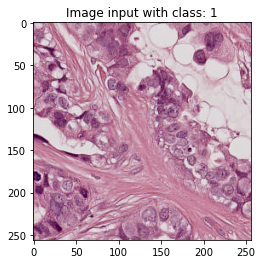

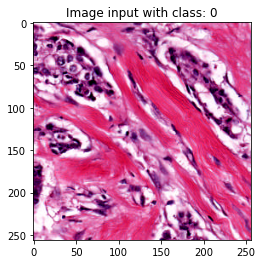

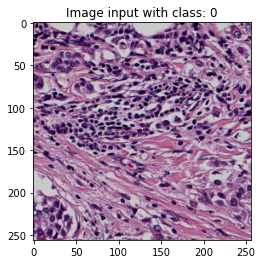

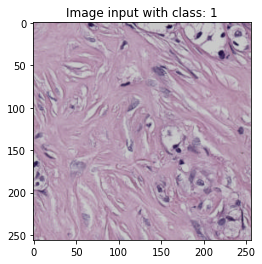

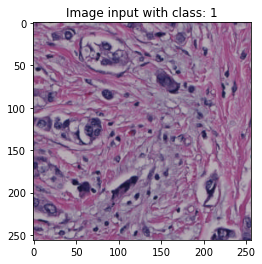

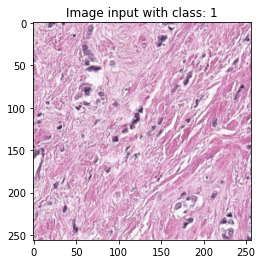

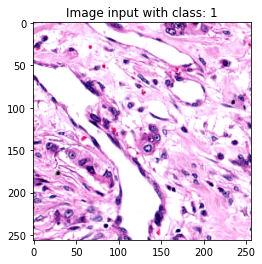

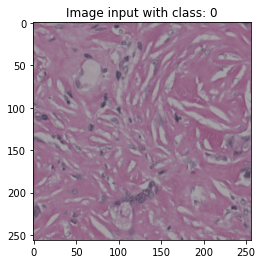

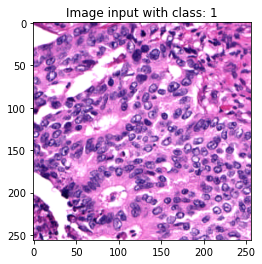

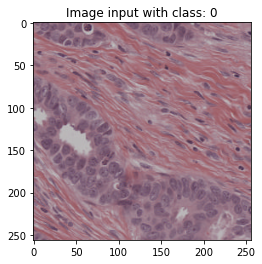

In [13]:
max_idx = 10
for i in range(len(labels)):
    if i < max_idx:
        img = np.transpose(imgs[i, :, :, :].numpy(), (1, 2, 0))
        lbl = labels[i]
        plt.imshow(img)
        plt.title(f"Image input with class: {lbl}")
        plt.show()

In [2]:
# Number of classes in the dataset
num_classes = 2
# Batch size for training
batch_size = 32
# Number of epochs to train for
num_epochs = 25

model_name = 'inceptionresnet'

InceptionResnet = True if model_name == 'inceptionresnet' else False
Inception = True if model_name == 'inception' else False

print(f"Model name: {model_name}")

SEED=42

# train_cases, val_cases, test_cases, dataloaders = get_seg_dataloaders(batch_size, SEED, Inception=Inception, InceptionResnet=InceptionResnet)
train_cases, val_cases, test_cases, dataloaders = get_her2status_dataloaders(batch_size, SEED, Inception=Inception, InceptionResnet=InceptionResnet)

Model name: inceptionresnet
Total tumour patches: 231872 
Number of training patches: 163040 
Number of validation patches 35200 
Number of test patches 33632


In [3]:
first_batch = next(iter(dataloaders['train']))

imgs = first_batch[0]
labels = first_batch[1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


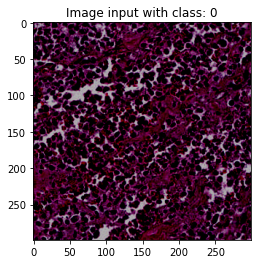

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


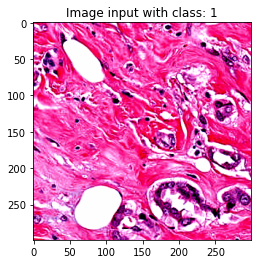

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


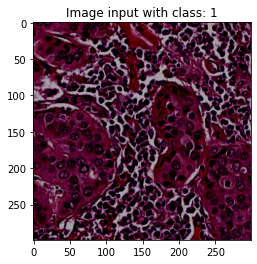

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


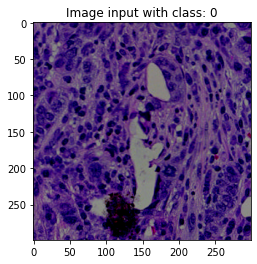

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


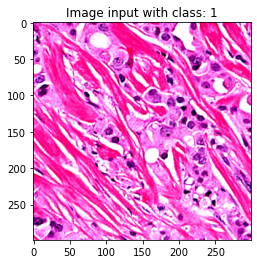

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


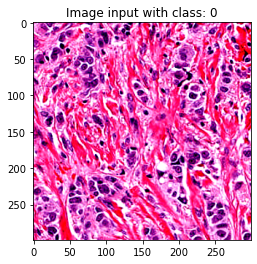

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


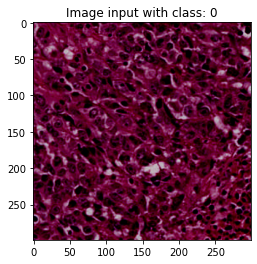

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


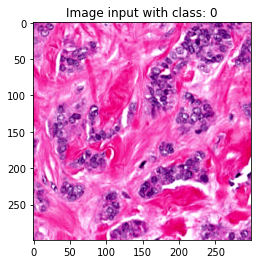

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


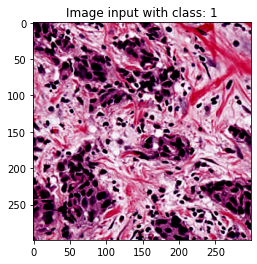

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


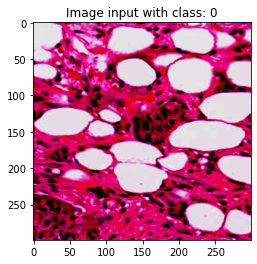

In [4]:
max_idx = 10
for i in range(len(labels)):
    if i < max_idx:
        img = np.transpose(imgs[i, :, :, :].numpy(), (1, 2, 0))
        lbl = labels[i]
        plt.imshow(img)
        plt.title(f"Image input with class: {lbl}")
        plt.show()